In [221]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os


In [2]:
full_df = pd.read_csv("series_data.csv", low_memory=False)
image_output_directory = "./images"
table_output_directory = "./tables"

os.makedirs(image_output_directory, exist_ok=True)
os.makedirs(table_output_directory, exist_ok=True)

full_df.head()

,step,value,timestamp,namespace,metric,run_id,tags,alpha,loss_function,lr,lr_method,method,num_classes,selectively_backpropagate,architecture,augmentation_policy,dataset,noise_level,greysacale
0,9.0,0.136682,2024-10-18 21:14:59.459,training,accuracy,CITL-399,"['mnasnet_small', 'cross_entropy', 'complete',...",0.29,cross_entropy,0.0005,plateau,score,10,True,mnasnet_small,cifar10,CIFAR10UB,0.1,NaN
1,19.0,0.102424,2024-10-18 21:15:01.188,training,accuracy,CITL-399,"['mnasnet_small', 'cross_entropy', 'complete',...",0.29,cross_entropy,0.0005,plateau,score,10,True,mnasnet_small,cifar10,CIFAR10UB,0.1,NaN
2,29.0,0.117028,2024-10-18 21:15:02.646,training,accuracy,CITL-399,"['mnasnet_small', 'cross_entropy', 'complete',...",0.29,cross_entropy,0.0005,plateau,score,10,True,mnasnet_small,cifar10,CIFAR10UB,0.1,NaN
3,39.0,0.106211,2024-10-18 21:15:04.105,training,accuracy,CITL-399,"['mnasnet_small', 'cross_entropy', 'complete',...",0.29,cross_entropy,0.0005,plateau,score,10,True,mnasnet_small,cifar10,CIFAR10UB,0.1,NaN
4,49.0,0.131573,2024-10-18 21:15:05.568,training,accuracy,CITL-399,"['mnasnet_small', 'cross_entropy', 'complete',...",0.29,cross_entropy,0.0005,plateau,score,10,True,mnasnet_small,cifar10,CIFAR10UB,0.1,NaN


In [3]:
def get_dataset(tags):
    if "CityscapesFine" in tags:
        return "Cityscapes"
    elif "CIFAR10" in tags:
        return "CIFAR10"
    else:
        raise ValueError(f"Unknown dataset: {tags}")

In [4]:
def get_purpose(tags):
    if "Method" in tags:
        return "Method"
    elif "Baseline" in tags:
        return "Baseline"
    elif "Standard" in tags:
        return "Standard"
    else:
        raise ValueError(f"Unknown method: {tags}")

In [124]:
def get_activation(tags):
    if "focal" in tags:
        return "FocalLoss"
    else:
        return "CrossEntropyLoss"

In [131]:
full_df["dataset"] = full_df["tags"].apply(lambda x: get_dataset(x))
full_df["timestamp"] = pd.to_datetime(full_df["timestamp"])
full_df["purpose"] = full_df["tags"].apply(lambda x: get_purpose(x))
full_df["loss_function"] = full_df["tags"].apply(lambda x: get_activation(x))

standard_trains = full_df[full_df["method"].isna()]
citl_trains = full_df[~full_df["method"].isna()]
assert len(standard_trains) + len(citl_trains) == len(full_df)

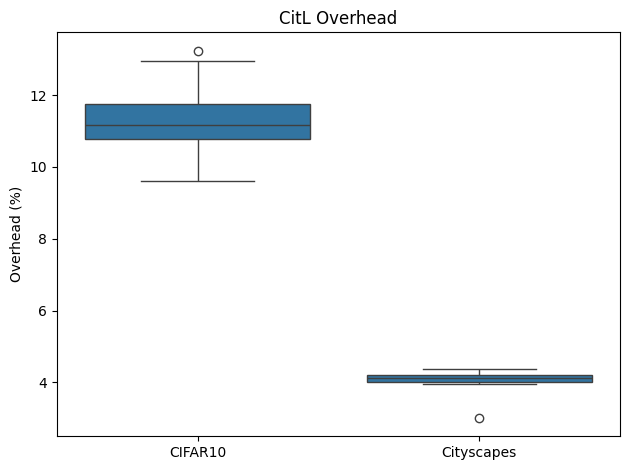

In [61]:
### OVERHEAD
standard_times = standard_trains.groupby(by=["run_id", "dataset"]).agg({"timestamp": ['max', 'min'], "step": "max"})
standard_times["duration"] = (standard_times["timestamp"]["max"] - standard_times["timestamp"]["min"]).dt.total_seconds()
standard_times["steps_per_second"] = standard_times["step"]["max"] / standard_times["duration"]
standard_times = standard_times.reset_index()[["dataset", "steps_per_second"]]
standard_times.columns = [col[0] for col in standard_times.columns]
standard_times = standard_times.groupby(by=["dataset"]).agg({"steps_per_second": "mean"}).reset_index()

citl_times = citl_trains.groupby(by=["run_id", "dataset"]).agg({"timestamp": ['max', 'min'], "step": "max"})
citl_times["duration"] = (citl_times["timestamp"]["max"] - citl_times["timestamp"]["min"]).dt.total_seconds()
citl_times["steps_per_second"] = citl_times["step"]["max"] / citl_times["duration"]
citl_times = citl_times.reset_index()[["dataset", "steps_per_second"]]
citl_times.columns = [col[0] for col in citl_times.columns]

joined_times = pd.merge(standard_times, citl_times, on="dataset", suffixes=("_standard", "_citl"))
joined_times["overhead"] = (joined_times["steps_per_second_standard"] / joined_times["steps_per_second_citl"]) - 1
joined_times = joined_times.reset_index()
joined_times.head()

joined_times["overhead"] = joined_times["overhead"] * 100

box_plot = sns.boxplot(data=joined_times, x="dataset", y="overhead")
ax = box_plot.axes
plt.title("CitL Overhead")
plt.ylabel("Overhead (%)")
plt.xlabel(None)
plt.tight_layout()
plt.savefig(f'{image_output_directory}/overhead.png', dpi=300, bbox_inches='tight')

joined_times.groupby(by=["dataset"])["overhead"].agg(["mean", "std", "min", "max"]).to_latex(f"{table_output_directory}/overhead.tex", float_format="%.2f")

In [172]:
test_metrics = full_df[full_df["metric"].str.startswith('test_')]
val_metrics = full_df[full_df["metric"].str.startswith('val_')]
weight_metrics = full_df[full_df["metric"].str.startswith('weight_')]

baseline_metrics = test_metrics[test_metrics["purpose"] == "Standard"]
method_metrics = test_metrics[test_metrics["purpose"] == "Method"]

baseline_val_metrics = val_metrics[val_metrics["purpose"] == "Standard"]
method_val_metrics = val_metrics[val_metrics["purpose"] == "Method"]


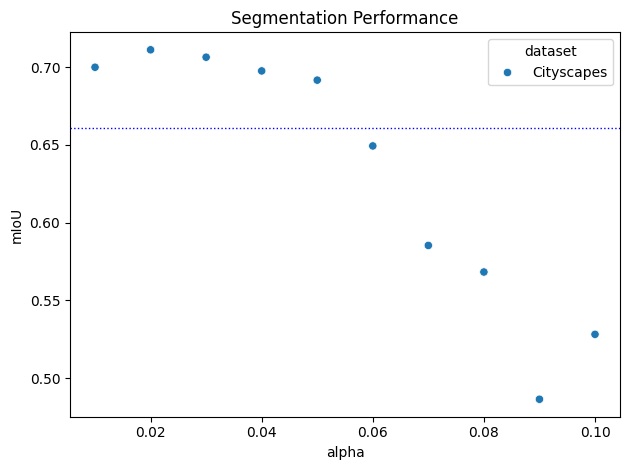

In [119]:
baseline_segmentation_metrics = baseline_metrics[baseline_metrics["dataset"] == "Cityscapes"]

method_segmentation_metrics = method_metrics[method_metrics["dataset"] == "Cityscapes"]

baseline_segmentation_metrics = baseline_segmentation_metrics.pivot(index=["run_id"], columns="metric", values=["value"])
baseline_segmentation_metrics.columns = [col[1] if col[1] else col[0] for col in baseline_segmentation_metrics.columns]

method_segmentation_metrics = method_segmentation_metrics.pivot(index=["run_id", "alpha", "dataset"], columns="metric", values=["value"]).reset_index().sort_values("alpha")
method_segmentation_metrics.columns = [col[1] if col[1] else col[0] for col in method_segmentation_metrics.columns ]

sns.scatterplot(data=method_segmentation_metrics, x="alpha", y="test_jaccard", hue="dataset")
plt.axhline(y=baseline_segmentation_metrics.iloc[0]["test_jaccard"], color='b', linestyle=':', linewidth=1)
plt.ylabel("mIoU")
plt.title("Segmentation Performance")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/segmentation_performance.png', dpi=300, bbox_inches='tight')


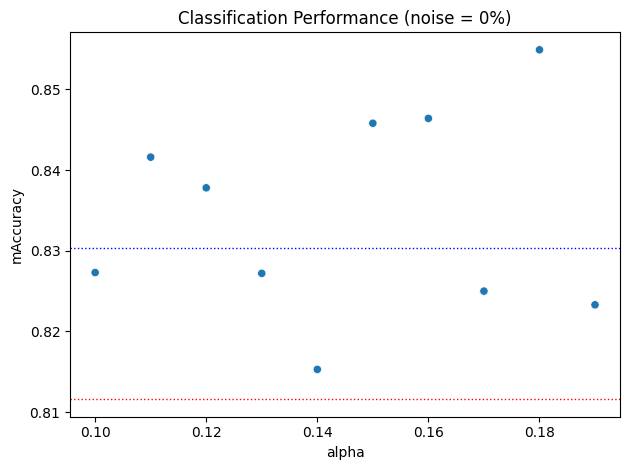

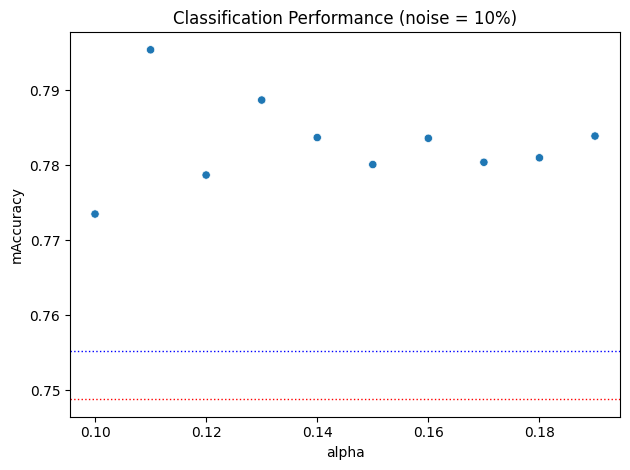

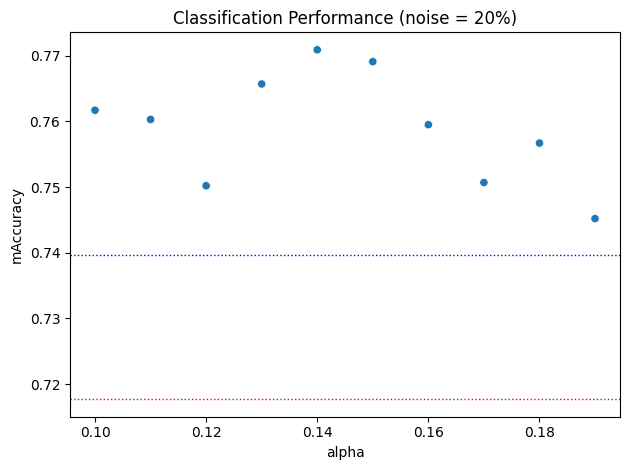

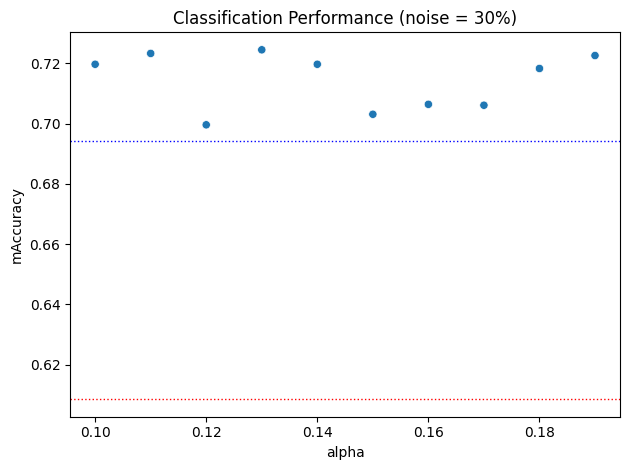

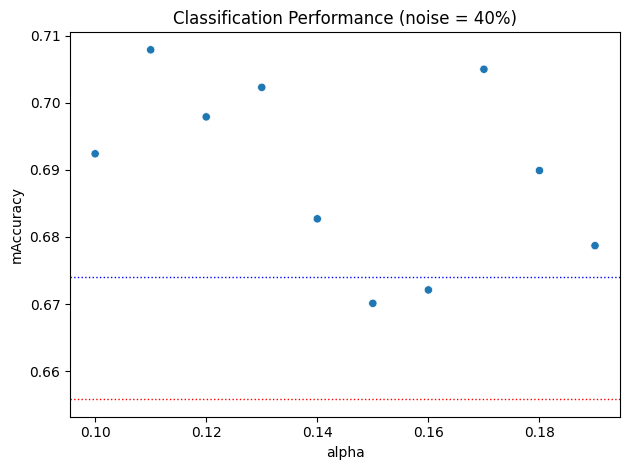

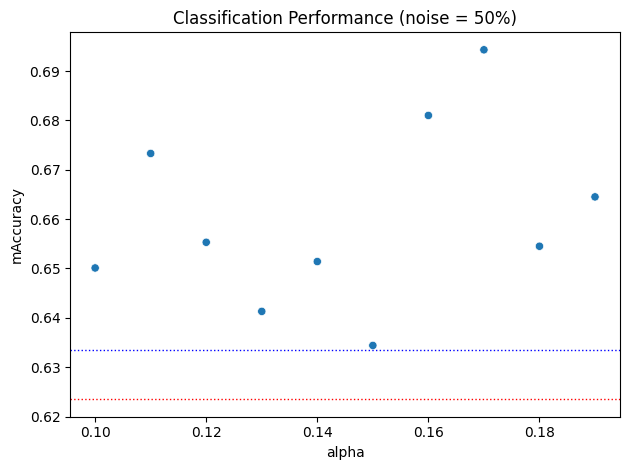

In [152]:
for noise_level in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    baseline_classification_metrics = baseline_metrics[(baseline_metrics["dataset"] == "CIFAR10")  & (baseline_metrics["noise_level"] == noise_level)]
    baseline_classification_metrics = baseline_classification_metrics.pivot(index=["run_id", "loss_function"], columns=["metric"], values=["value"])
    baseline_classification_metrics.columns = [col[1] if col[1] else col[0] for col in baseline_classification_metrics.columns]
    baseline_classification_metrics = baseline_classification_metrics.reset_index()

    method_classification_metrics = method_metrics[(method_metrics["dataset"] == "CIFAR10") & (method_metrics["noise_level"] == noise_level)]
    method_classification_metrics = method_classification_metrics[(method_classification_metrics["alpha"] >= 0.1) & (method_classification_metrics["alpha"] < 0.2)]

    method_classification_metrics = method_classification_metrics.pivot(index=["run_id", "alpha", "dataset"], columns="metric", values=["value"]).reset_index().sort_values("alpha")
    method_classification_metrics.columns = [col[1] if col[1] else col[0] for col in method_classification_metrics.columns ]

    sns.scatterplot(data=method_classification_metrics, x="alpha", y="test_accuracy", hue="dataset", legend=False)
    plt.plot()
    plt.axhline(y=baseline_classification_metrics[baseline_classification_metrics["loss_function"] == "CrossEntropyLoss"].iloc[0]["test_accuracy"], color='b', linestyle=':', linewidth=1)
    plt.axhline(y=baseline_classification_metrics[baseline_classification_metrics["loss_function"] == "FocalLoss"].iloc[0]["test_accuracy"], color='r', linestyle=':', linewidth=1)
    plt.ylabel("mAccuracy")
    plt.title(f"Classification Performance (noise = {int(noise_level*100)}%)")
    plt.tight_layout()
    plt.savefig(f'{image_output_directory}/classification_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


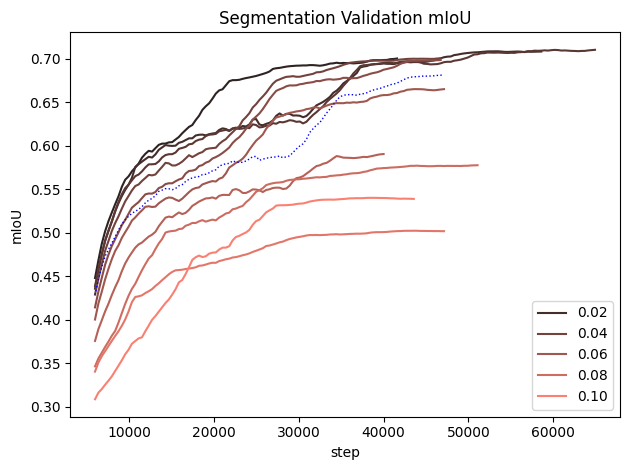

In [82]:
baseline_val_segmentation_metrics = baseline_val_metrics[baseline_val_metrics["dataset"] == "Cityscapes"]
method_val_segmentation_metrics = method_val_metrics[method_val_metrics["dataset"] == "Cityscapes"]

method_val_segmentation_metrics = method_val_segmentation_metrics.pivot(index=["run_id", "alpha", "dataset", "step"], columns="metric", values=["value"]).reset_index().sort_values("alpha")
method_val_segmentation_metrics.columns = [col[1] if col[1] else col[0] for col in method_val_segmentation_metrics.columns ]

baseline_val_segmentation_metrics = baseline_val_segmentation_metrics.pivot(index=["run_id", "dataset", "step"], columns="metric", values=["value"]).reset_index()
baseline_val_segmentation_metrics.columns = [col[1] if col[1] else col[0] for col in baseline_val_segmentation_metrics.columns ]

palette = sns.color_palette("dark:salmon", as_cmap=True)

window = 15

baseline_val_segmentation_metrics['val_jaccard_smoothed'] = baseline_val_segmentation_metrics['val_jaccard'].rolling(window=window).mean()
method_val_segmentation_metrics = method_val_segmentation_metrics.sort_values("step", ascending=True)
method_val_segmentation_metrics['val_jaccard_smoothed'] = method_val_segmentation_metrics.groupby('alpha')['val_jaccard'].transform(lambda x: x.rolling(window=window).mean())

fig, ax = plt.subplots()
sns.lineplot(data=method_val_segmentation_metrics, x="step", y="val_jaccard_smoothed", hue="alpha", ax=ax, palette=palette, legend='auto')
sns.lineplot(data=baseline_val_segmentation_metrics, x="step", y="val_jaccard_smoothed", color='b', linestyle=':', linewidth=1, ax=ax)
plt.ylabel("mIoU")
plt.title("Segmentation Validation mIoU")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/segmentation_val_miou.png', dpi=300, bbox_inches='tight')


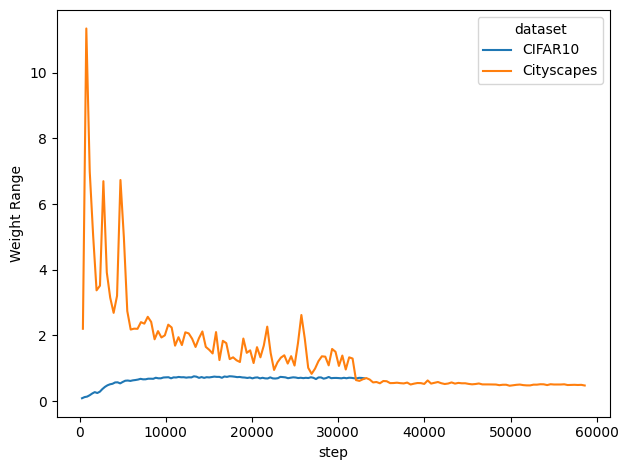

In [86]:
cityscapes_best = ( (weight_metrics["dataset"] == "Cityscapes") & (weight_metrics["alpha"] == 0.02))
cifar_best = ( (weight_metrics["dataset"] == "CIFAR10") & (weight_metrics["noise_level"] == 0.0) & (weight_metrics["alpha"] == 0.02))
best_weight_metrics = weight_metrics[ cityscapes_best | cifar_best ]
best_weight_metrics = best_weight_metrics.pivot(index=["step", "dataset"], columns="metric", values=["value"]).reset_index()
best_weight_metrics.columns = [col[1] if col[1] else col[0] for col in best_weight_metrics.columns ]

sns.lineplot(best_weight_metrics, x="step", y="weight_range", hue="dataset")
plt.ylabel("Weight Range")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/weight_range.png', dpi=300, bbox_inches='tight')

In [264]:
best_test_metrics = test_metrics.fillna(0)
best_test_metrics = best_test_metrics.groupby(by=["purpose", "dataset", "metric", "alpha", "noise_level"]).agg("max")[["value"]].reset_index()
allowed_metrics = [
    "test_accuracy",
    "test_jaccard",
]
best_test_metrics = best_test_metrics[(best_test_metrics["metric"].isin(allowed_metrics))]
best_test_metrics = best_test_metrics[(best_test_metrics["purpose"].isin(["Method", "Standard"]))]
best_test_metrics["metric"] = best_test_metrics["metric"].apply(lambda x: x.replace("test_", "").title())

best_method_metrics = best_test_metrics[best_test_metrics["purpose"] == "Method"].groupby(["dataset", "noise_level", "metric"]).agg("max")[["value"]].reset_index()
best_method_metrics = best_test_metrics.merge(best_method_metrics, on=["dataset", "noise_level", "metric", "value"], how="inner")

best_standard_metrics = best_test_metrics[best_test_metrics["purpose"] == "Standard"].groupby(["dataset", "noise_level", "metric"]).agg("max")[["value"]].reset_index()
best_standard_metrics = best_standard_metrics.groupby(["dataset", "noise_level", "metric"]).agg("max")[["value"]].reset_index()

best_metrics = best_method_metrics.merge(best_standard_metrics, on=["dataset", "noise_level", "metric"], how="inner")
best_metrics = best_metrics.rename(columns={"value_x": "Method", "value_y": "Baseline", "noise_level": "Noise"})
best_metrics["Method"] = best_metrics["Method"] * 100
best_metrics["Baseline"] = best_metrics["Baseline"] * 100
best_metrics["Delta"] = best_metrics["Method"] - best_metrics["Baseline"]
best_metrics["Noise"] = best_metrics["Noise"] * 100
best_metrics["Noise"] = best_metrics["Noise"].map(int)

best_metrics = best_metrics.sort_values(["dataset", "Noise"])
best_metrics = best_metrics.drop(columns=['purpose'])
best_metrics = best_metrics.set_index(['dataset', 'metric', 'Noise'])
best_metrics.to_latex(f"{table_output_directory}/best_test_metrics.tex", float_format="%.2f")


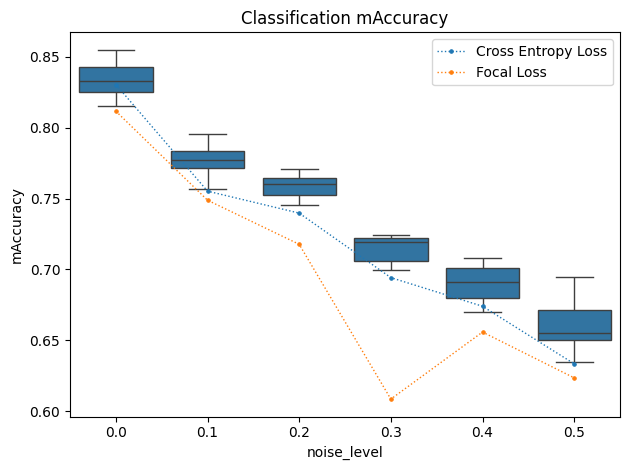

In [314]:
best_test_metrics = test_metrics.fillna(0)
cifar_metrics = best_test_metrics[(best_test_metrics["dataset"] == "CIFAR10") & (best_test_metrics["metric"] == "test_accuracy")]
standard_cifar_metrics = cifar_metrics[cifar_metrics["purpose"] == "Standard"]
method_cifar_metrics = cifar_metrics[cifar_metrics["purpose"] == "Method"]

standard_cifar_metrics = standard_cifar_metrics.sort_values("noise_level").sort_values("loss_function")
method_cifar_metrics = method_cifar_metrics.sort_values("noise_level")

fig, ax = plt.subplots()
sns.boxplot(data=method_cifar_metrics, x="noise_level", y="value", ax=ax, legend='auto')
sns.pointplot(data=standard_cifar_metrics, x="noise_level", y="value", hue="loss_function", linestyle=':', linewidth=1, ax=ax)
plt.ylabel("mAccuracy")
plt.title("Classification mAccuracy")
legend = ax.legend()
legend.texts[0].set_text("Cross Entropy Loss")
legend.texts[1].set_text("Focal Loss")
plt.tight_layout()
plt.savefig(f'{image_output_directory}/classification_performance.png', dpi=300, bbox_inches='tight')


In [356]:
best_classification_results = test_metrics.fillna(0)
best_classification_results["value"] = best_classification_results["value"] * 100
best_classification_results = best_classification_results[
    ( best_classification_results["dataset"] == "CIFAR10") &
    ( best_classification_results["purpose"] == "Method") &
    (
        ((best_classification_results["noise_level"] == 0.0) & (best_classification_results["alpha"] == 0.18)) |
        ((best_classification_results["noise_level"] == 0.1) & (best_classification_results["alpha"] == 0.11)) |
        ((best_classification_results["noise_level"] == 0.2) & (best_classification_results["alpha"] == 0.14)) |
        ((best_classification_results["noise_level"] == 0.3) & (best_classification_results["alpha"] == 0.13)) |
        ((best_classification_results["noise_level"] == 0.4) & (best_classification_results["alpha"] == 0.11)) |
        ((best_classification_results["noise_level"] == 0.5) & (best_classification_results["alpha"] == 0.17))
    )
]

best_classification_results = best_classification_results.pivot(index=["noise_level"], columns="metric", values=["value"])
best_classification_results.columns = [col[1] if col[1] else col[0] for col in best_classification_results.columns]
best_classification_results = best_classification_results.filter(regex='^test_accuracy')
best_classification_results = best_classification_results.rename(columns={"test_accuracy": "Overall"})
best_classification_results.columns = [col.replace('test_accuracy_', '').capitalize() for col in best_classification_results.columns]
best_classification_results = best_classification_results.T
overall_row = best_classification_results.loc['Overall']
best_classification_results = best_classification_results.drop('Overall')
best_classification_results = pd.concat([best_classification_results, overall_row.to_frame().T])

standard_metrics = test_metrics.fillna(0)
standard_metrics["value"] = standard_metrics["value"] * 100

standard_metrics = standard_metrics[
   (standard_metrics["dataset"] == "CIFAR10") &
   (standard_metrics["purpose"] == "Standard") &
   (standard_metrics["loss_function"] == "CrossEntropyLoss") ]

standard_metrics = standard_metrics.pivot(index=["noise_level"], columns="metric", values=["value"])
standard_metrics.columns = [col[1] if col[1] else col[0] for col in standard_metrics.columns]
standard_metrics = standard_metrics.filter(regex='^test_accuracy')
standard_metrics = standard_metrics.rename(columns={"test_accuracy": "Overall"})
standard_metrics.columns = [col.replace('test_accuracy_', '').capitalize() for col in standard_metrics.columns]
standard_metrics = standard_metrics.T
overall_row = standard_metrics.loc['Overall']
standard_metrics = standard_metrics.drop('Overall')
standard_metrics = pd.concat([standard_metrics, overall_row.to_frame().T])

full_metrics = standard_metrics.merge(best_classification_results, left_index=True, right_index=True, suffixes=("_standard", "_method"))
full_metrics.columns = pd.MultiIndex.from_tuples([tuple(c.split('_')) for c in full_metrics.columns])
delta_columns = []

# Loop through each unique noise level
for level in set(level for level, method in full_metrics.columns):
    if (level, 'method') in full_metrics.columns and (level, 'standard') in full_metrics.columns:
        # Calculate delta as method - standard
        delta_column_name = (level, 'delta')  # New column name
        full_metrics[delta_column_name] = full_metrics[(level, 'method')] - full_metrics[(level, 'standard')]
        delta_columns.append(delta_column_name)


sorted_columns = sorted(full_metrics.columns, key=lambda x: (x[0], x[1] != 'standard'))
full_metrics = full_metrics[sorted_columns]
full_metrics.to_latex(f"{table_output_directory}/classification_metrics_by_class.tex", float_format="%.1f")

